<a href="https://colab.research.google.com/github/MBNHL/ai-ml-portfolio/blob/main/multilabel_toxic_comment_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multilabel Toxic Comment Classification**
# *Un approccio ibrido CNN–BiGRU con meccanismo di attenzione per il filtraggio automatico dei commenti tossici*


## Descrizione del Progetto

Il progetto mira a sviluppare un **sistema automatico di filtraggio dei commenti tossici** basato su tecniche di **deep learning**.  
L’obiettivo è eseguire una **classificazione multi-label** dei commenti in **sei categorie** di tossicità (*toxic, severe_toxic, obscene, threat, insult, identity_hate*) utilizzando un dataset di circa **160.000 commenti etichettati**.

## Architettura del Modello

Approccio **ibrido CNN–BiGRU** con **Attention Mechanism**:
- **Convolutional layers** per estrarre feature locali.
- **Bidirectional GRU/LSTM** per catturare relazioni sequenziali e contesto.
- Ottimizzazione con **Adam** e gestione training tramite **callbacks** (es. *Early Stopping* su F1 pesata).

## Stack Tecnologico

- **Linguaggio/ambiente:** Python
- **Analisi & manipolazione dati:** `Pandas`, `NumPy`
- **Visualizzazione:** `Matplotlib`, `Seaborn`, `WordCloud`
- **NLP & ML:** `Scikit-learn`, `NLTK`
- **Deep Learning:** `TensorFlow`, `Keras` (layers, models, callbacks, optimizers)

## Fasi del Progetto

1. **Preprocessing dei dati:** tokenizzazione, normalizzazione, **bilanciamento delle classi**.
2. **Sviluppo & training:** split del dataset, tuning dei parametri e **ottimizzazione avanzata**.
3. **Inferenza & predizione:** output di un **vettore binario a 6 elementi** (presenza/assenza di ciascuna classe).
4. **Valutazione delle performance:** metriche di **accuracy** e **F1-score**, con **matrici di confusione** per classe.


### **Indice**

---
#### 1. **Analisi Esplorativa dei Dati (EDA)**
- 1.1 Analisi statistica descrittiva delle categorie
- 1.2 Matrice di correlazione tra categorie di tossicità
- 1.3 Analisi della distribuzione del numero di label per commento
- 1.4 Analisi delle combinazioni di categorie di tossicità
- 1.5 Analisi delle TOP 30 combinazioni modellabili (escluso “Non tossico”)
- 1.6 Riepilogo statistico della distribuzione delle categorie tossiche
- 1.7 Visualizzazione Word Cloud per categoria (basata su TF-IDF)

---
#### 2. **Implementazione del Modello**
- 2.1 Split del dataset
- 2.2 Pre-processing del testo
- 2.3 Bilanciamento delle classi
- 2.4 Class Weights e Loss pesata personalizzata
- 2.5 Callback personalizzata con Early Stopping basata su F1-score
- 2.6 Definizione del modello ibrido CNN + BiGRU con meccanismo di attenzione

---
#### 3. **Addestramento e Visualizzazione delle Metriche**
- 3.1 Training del modello con Early Stopping e riduzione adattiva del learning rate
- 3.2 Visualizzazione delle metriche di addestramento e valutazione
 (Loss, Accuracy, Precision, Recall, F1-score)

---
#### 4. **Valutazione Finale e Analisi dei Risultati**
- 4.1 Ricaricamento del modello con miglior F1-score
- 4.2 Ottimizzazione delle soglie di classificazione sul validation set
- 4.3 Valutazione finale sul test set
- 4.4 Confronto tra soglia di default e soglia ottimizzata
- 4.5 Visualizzazione delle matrici di confusione per ciascuna classe
- 4.6 Analisi dettagliata delle matrici di confusione – Classificazione tossicità
 (es. Severe Toxic, Threat, Insult, Identity Hate)

---
#### 5. **Conclusioni e Prospettive Future**
- 5.1 Strategie di miglioramento adottate
- 5.2 Criticità e limiti intrinseci dei dati
- 5.3 Punti di forza del processo implementato
- 5.4 Implementazioni e miglioramenti futuri
- 5.5 Conclusioni sui risultati del modello
- 5.6 Prospettive di miglioramento e sviluppo futuro

In [ ]:
!pip install scikit-multilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 5.5 MB/s eta 0:00:00


In [ ]:
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# ================================================================
# IMPORT DEPENDENCY
# ================================================================

# Librerie per la manipolazione e visualizzazione dei dati
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from wordcloud import WordCloud

# Librerie per il machine learning
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    precision_recall_fscore_support, accuracy_score, roc_auc_score,
    confusion_matrix, precision_score, recall_score, f1_score,
    classification_report
)
from skmultilearn.model_selection import IterativeStratification


# TensorFlow e Keras per il deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, LSTM, Embedding, Bidirectional,
    GRU, Dropout, BatchNormalization, Dense, GlobalMaxPooling1D
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

import tensorflow.keras as keras
from keras.layers import concatenate

import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize



In [ ]:
BASE_URL = "https://proai-datasets.s3.eu-west-3.amazonaws.com/"
df = pd.read_csv(BASE_URL+"Filter_Toxic_Comments_dataset.csv")

print("\n=== FASE 1: Preparazione Iniziale del Dataset ===")
print(f"Dimensioni del dataset: {df.shape}")


=== FASE 1: Preparazione Iniziale del Dataset ===
Dimensioni del dataset: (159571, 8)


In [ ]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


In [ ]:
df[df['sum_injurious']==2]

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
51,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,1,0,1,0,0,0,2
58,My Band Page's deletion. You thought I was gon...,1,0,1,0,0,0,2
79,Hi! I am back again!\nLast warning!\nStop undo...,1,0,0,1,0,0,2
86,"Would you both shut up, you don't run wikipedi...",1,0,0,0,1,0,2
168,"You should be fired, you're a moronic wimp who...",1,0,0,0,1,0,2
...,...,...,...,...,...,...,...,...
159253,what do you mean \n\nwhy don't you keep your n...,1,0,1,0,0,0,2
159334,"Horse's ass \n\nSeriously, dude, what's that h...",1,0,1,0,0,0,2
159449,I think he is a gay fag!!!,1,0,0,0,0,1,2
159514,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0,2


In [ ]:
len(df)

159571

#1. **Analisi Esplorativa dei Dati (EDA)**


###1.1 **Analisi Statistica Descrittiva delle Categorie**

Il grafico evidenzia la distribuzione delle categorie di tossicità, utile per individuare squilibri tra classi. In questo caso **il dataset è fortemente sbilanciato**, quindi sarà necessario applicare tecniche di riequilibrio per migliorare le prestazioni del modello sulle classi rare.

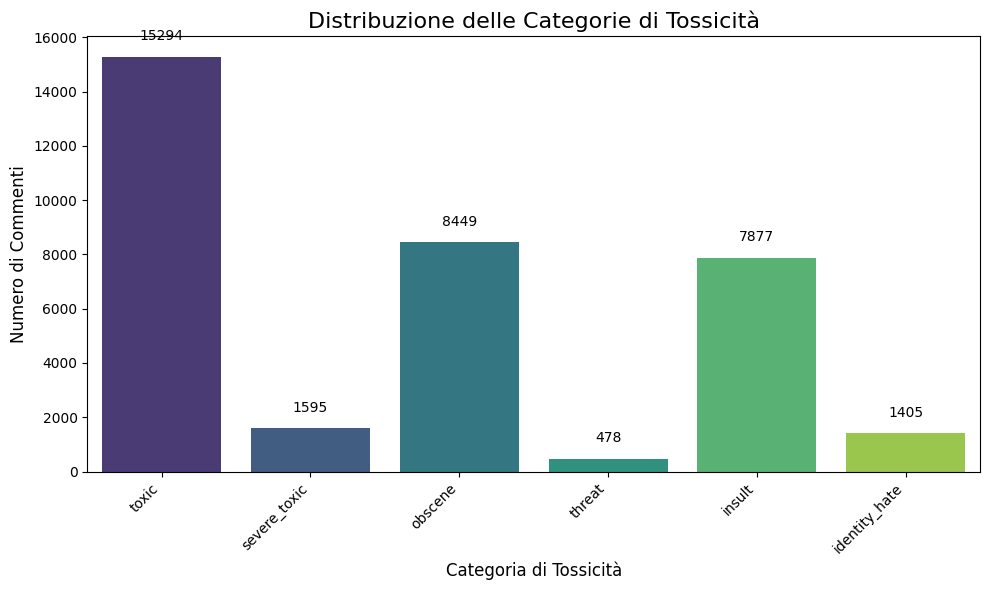

In [ ]:
# ================================================================
# ANALISI DELLE CATEGORIE
# ================================================================

# Seleziono le colonne relative alle categorie di tossicità
toxic_categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Calcolo il numero di occorrenze per ogni categoria
category_counts = df[toxic_categories].sum()

# Creo il grafico a barre
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')

# Etichette degli assi
plt.title('Distribuzione delle Categorie di Tossicità', fontsize=16)
plt.xlabel('Categoria di Tossicità', fontsize=12)
plt.ylabel('Numero di Commenti', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Aggiunge il conteggio sopra ogni barra
for index, value in enumerate(category_counts.values):
    plt.text(index, value + 500, str(value), ha='center', va='bottom', fontsize=10)


plt.tight_layout()
plt.show()

###1.2 **Matrice di Correlazione tra Categorie di Tossicità**

La matrice di correlazione mostra le relazioni tra le etichette ed è utile per far emergere l'esistenza di pattern di co-occorrenza: toxic è fortemente correlata con obscene (0.68) e insult (0.65), ma poco con threat. Poiché **le etichette non sono mutuamente esclusive** e alcune co-occorrono frequentemente (es. toxic + insult + obscene), è opportuno **considerare approcci di multi-label learning che sfruttino queste relazioni**.

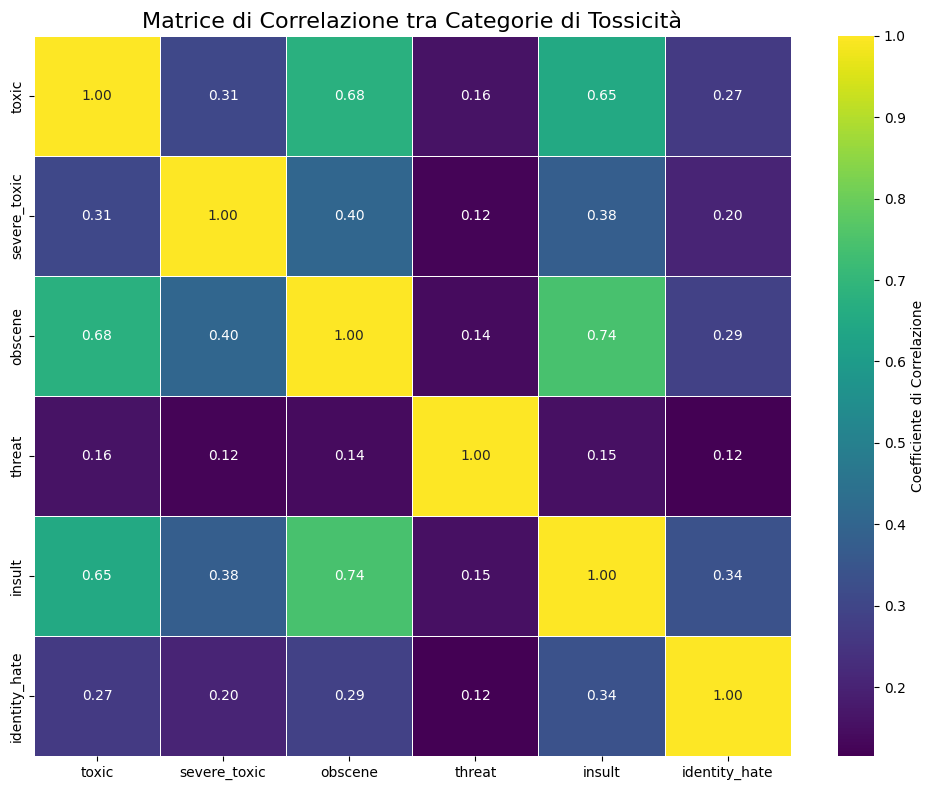

In [ ]:
# ================================================================
# MATRICE DI CORRELAZIONE
# ================================================================

# La funzione .corr() calcola la correlazione pairwise tra le colonne
correlation_matrix = df[toxic_categories].corr()

# Creo la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='viridis',
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Coefficiente di Correlazione'}
)

# Titolo del grafico
plt.title('Matrice di Correlazione tra Categorie di Tossicità', fontsize=16)


plt.tight_layout()
plt.show()



###1.3 **Analisi delle Distribuzioni delle Label per Commento**

Calcola per ogni commento la sua composizione in termini di categorie tossiche attive e ne visualizza la distribuzione. Questo aiuta a valutare lo squilibrio tra classi, in particolare:

- la maggior parte dei commenti (143k) è non tossica, pochi hanno una o più categorie attive.

- implica il rischio di modelli che predicono sempre "non tossico" con alta accuracy ma bassa utilità.

Il grafico conferma la necessità di applicare strategie robuste di ribilanciamento del dataset e approcci multi-label.

Distribuzione del numero di label per commento:
num_labels
0    143346
1      6360
2      3480
3      4209
4      1760
5       385
6        31
Name: count, dtype: int64




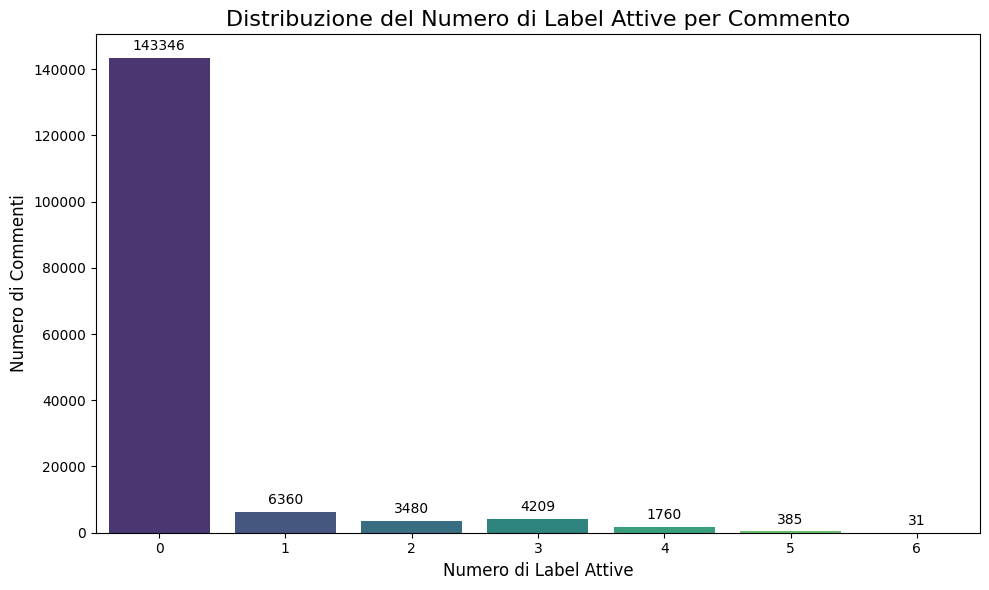

In [ ]:
# ================================================================
# DISTRIBUZIONE DELLE LABEL ATTIVE PER COMMENTO
# ================================================================


# Calcolo la somma delle label attive per ogni commento
df['num_labels'] = df[toxic_categories].sum(axis=1)

# Calcolo la distribuzione
label_distribution = df['num_labels'].value_counts().sort_index()

# Stampa la distribuzione
print("Distribuzione del numero di label per commento:")
print(label_distribution)
print("\n")

# Creo un grafico a barre per visualizzare la distribuzione
plt.figure(figsize=(10, 6))
sns.barplot(x=label_distribution.index, y=label_distribution.values, palette='viridis')

# Titolo e etichette dgli assi
plt.title('Distribuzione del Numero di Label Attive per Commento', fontsize=16)
plt.xlabel('Numero di Label Attive', fontsize=12)
plt.ylabel('Numero di Commenti', fontsize=12)

# Conteggio sopra ogni barra
for index, value in enumerate(label_distribution.values):
    plt.text(index, value + (label_distribution.max() * 0.01), str(value), ha='center', va='bottom', fontsize=10)


plt.tight_layout()
plt.show()

###1.4 **Analisi delle combinazioni di Categorie di Tossicità**

Calcola la percentuale di ogni combinazione di etichette sul totale dei commenti. Questa analisi è utile perchè ci permette di iniziare a stimare la complessità dei pattern linguistici.

Risultato: la maggioranza (≈90%) è non tossica, **poche combinazioni hanno 3+ etichette. Il problema di multi-label è raro ma rilevante.**

Il modello RNN che andremo a definnire dovrà catturare le relazioni semantiche e le dipendenze tra categorie.

Serviranno metriche adatte a valutare i risultati in presenza di multi-label e classi sbilanciate come l'F1.

In [ ]:
# ================================================================
# COMBINAZIONI DI CATEGORIE DI TOSSICITA'
# ================================================================


# Funzione per ottenere la stringa della combinazione di label per ogni commento
def get_label_combination_string(row, all_categories):
    active_labels = [col for col in all_categories if row[col] == 1]
    if not active_labels:
        return 'Non tossico'
    return '+'.join(sorted(active_labels))

# Applico la funzione per creare la colonna delle combinazioni
df['label_combination_string'] = df.apply(get_label_combination_string, axis=1, all_categories=toxic_categories)

# Calcolo il conteggio di ogni combinazione
combination_counts = df['label_combination_string'].value_counts()

# Calcolo la percentuale di ogni combinazione sul totale dei commenti
total_comments = len(df)
combination_percentages = (combination_counts / total_comments) * 100

# Creo un DataFrame per la visualizzazione tabellare
combinations_df = pd.DataFrame({
    'Conteggio': combination_counts,
    'Percentuale': combination_percentages.round(2)
})

# Ordino il DataFrame delle combinazioni per conteggio decrescente
combinations_df = combinations_df.sort_values(by='Conteggio', ascending=False)

print("Distribuzione delle Combinazioni di Categorie di Tossicità:")
print(combinations_df)
print("\n")

Distribuzione delle Combinazioni di Categorie di Tossicità:
                                                    Conteggio  Percentuale
label_combination_string                                                  
Non tossico                                            143346        89.83
toxic                                                    5666         3.55
insult+obscene+toxic                                     3800         2.38
obscene+toxic                                            1758         1.10
insult+toxic                                             1215         0.76
insult+obscene+severe_toxic+toxic                         989         0.62
identity_hate+insult+obscene+toxic                        618         0.39
obscene                                                   317         0.20
insult                                                    301         0.19
identity_hate+insult+obscene+severe_toxic+toxic           265         0.17
insult+obscene                          

##1.5 **Analisi sulle Combinazioni Multilabel delle Categorie di Tossicità**

Mostra le TOP 30 combinazioni più frequenti di categorie tossiche (esclusi i non tossici).

Le combinazioni più comuni sono:
- toxic
- insult+obscene+toxic
- obscene+toxic

Rende più chiare le considerazioni fatte sopra, mostra quali mix di tossicità sono più frequenti.


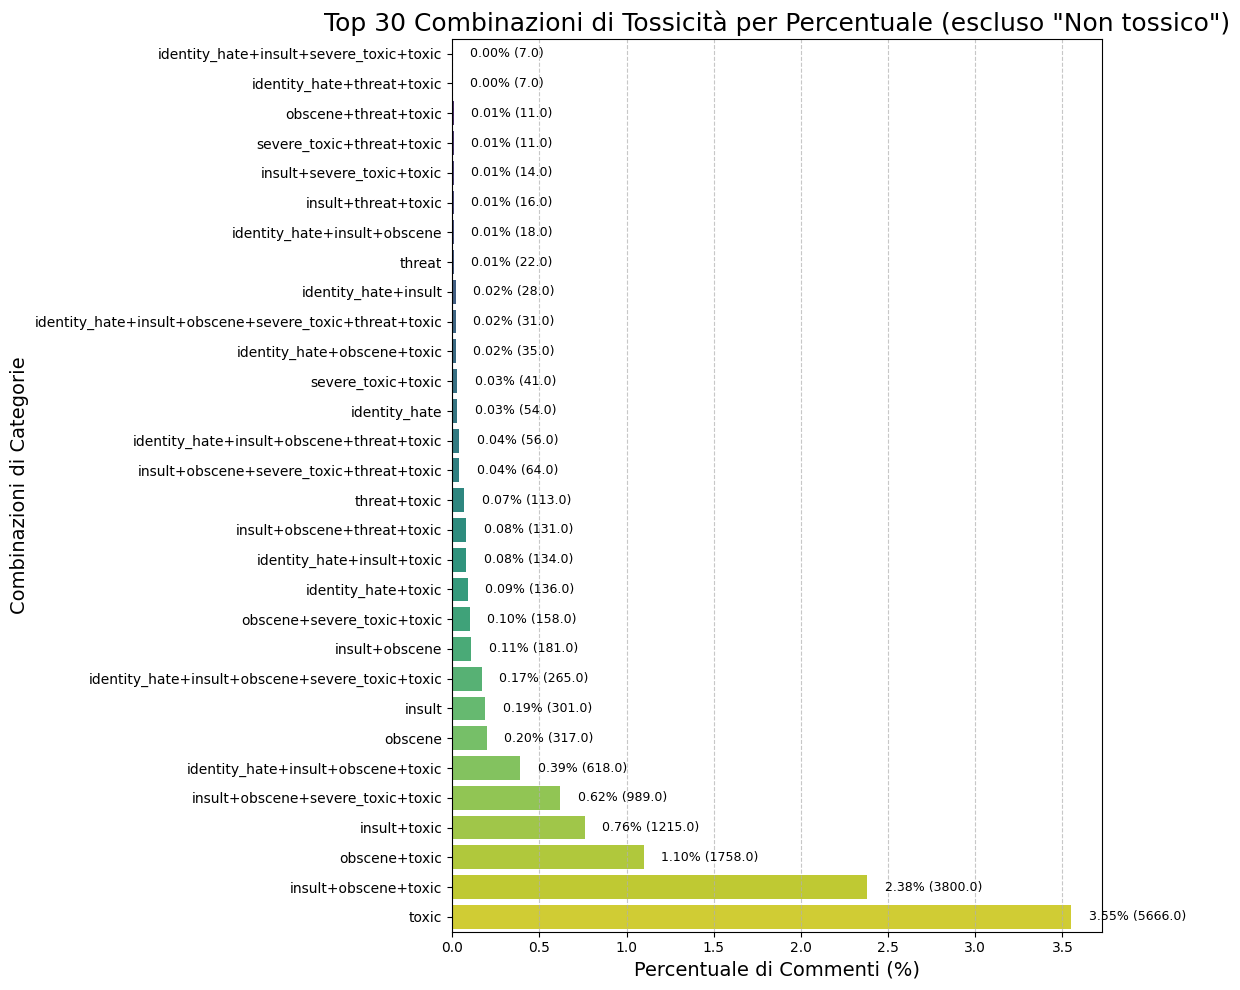

In [ ]:
# ================================================================
# TOP COMBINAZIONI DI TOSSICITA'
# ================================================================


# Filtro il DataFrame per rimuovere la riga "Non tossico"
# Aggiungo errors='ignore' per evitare errori se la categoria non fosse presente
combinations_df_filtrato = combinations_df.drop('Non tossico', errors='ignore')

# Generazione del Grafico a Barre Orizzontali
N_combinations_to_show = 30 # Imposto a 30 il numero di combinazioni da mostrare

# Ordina il DataFrame filtrato in ordine decrescente per 'Conteggio'e poi seleziono le prime N combinazioni.
top_combinations = combinations_df_filtrato.sort_values(by='Conteggio', ascending=False).head(N_combinations_to_show)

# Ordino al contrario per il plot orizzontale
top_combinations = top_combinations.sort_values(by='Conteggio', ascending=True)


plt.figure(figsize=(12, 10))
sns.barplot(
    x=top_combinations['Percentuale'],
    y=top_combinations.index,
    palette='viridis',
    orient='h'

)
plt.title(f'Top {len(top_combinations)} Combinazioni di Tossicità per Percentuale (escluso "Non tossico")', fontsize=18)
plt.xlabel('Percentuale di Commenti (%)', fontsize=14)
plt.ylabel('Combinazioni di Categorie', fontsize=14)


for i, (combination, row) in enumerate(top_combinations.iterrows()):
    percentage = row['Percentuale']
    count = row['Conteggio']
    plt.text(percentage + 0.1, i, f'{percentage:.2f}% ({count})',
             ha='left', va='center', fontsize=9)

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

##1.6 **Riepilogo statistico della distribuzione delle categorie tossiche**

Di seguito un riepilogo statistico che mostra come si distribuisce il numero di categorie tossiche attive per ciascun commento.

Mostra la distribuzione della multi-label classification, ma solo tra i commenti tossici:

- 39.2% dei commenti tossici ha solo 1 categoria attiva.

- 21.4% dei commenti tossici ha 2 categorie attive.

- 25.9% dei commenti tossici ha 3 categorie attive(i casi multi-label sono rilevanti e non trascurabili).

- Pochi commenti hanno 5 o 6 categorie attive (situazioni estreme).

Riepilogo statistico della distribuzione delle categorie tossiche (esclusi i non tossici):

1    39.2
2    21.4
3    25.9
4    10.8
5     2.4
6     0.2

--------------------------------------------------
Numero totale di commenti tossici analizzati: 16225
Numero medio di categorie tossiche per commento: 2.16
Mediana del numero di categorie tossiche per commento: 2.00
Moda del numero di categorie tossiche per commento: [1]
--------------------------------------------------



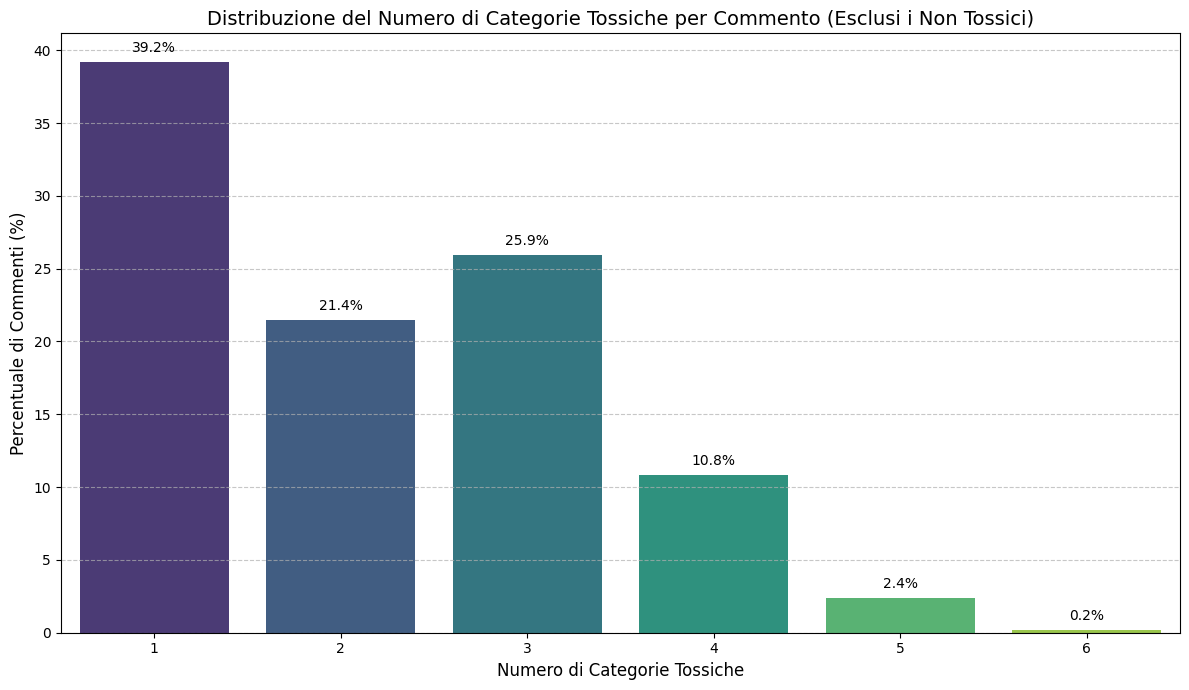

In [ ]:
# ================================================================
# RIEPILOGO STATISTICO
# ================================================================

# Calcola il numero di categorie tossiche per ogni commento
df['num_toxic_categories'] = df[toxic_categories].sum(axis=1)

# Escludo i commenti non tossici
toxic_comments_df = df[df['num_toxic_categories'] > 0]

# Calcolo la distribuzione del numero di categorie tossiche
category_counts = toxic_comments_df['num_toxic_categories'].value_counts().sort_index()
category_percentages = (category_counts / len(toxic_comments_df)) * 100

# Riepilogo statistico
print("Riepilogo statistico della distribuzione delle categorie tossiche (esclusi i non tossici):\n")
print(category_percentages.round(1).to_string(name=False, header=False,))
print("\n--------------------------------------------------")
print(f"Numero totale di commenti tossici analizzati: {len(toxic_comments_df)}")
print(f"Numero medio di categorie tossiche per commento: {toxic_comments_df['num_toxic_categories'].mean():.2f}")
print(f"Mediana del numero di categorie tossiche per commento: {toxic_comments_df['num_toxic_categories'].median():.2f}")
print(f"Moda del numero di categorie tossiche per commento: {toxic_comments_df['num_toxic_categories'].mode().tolist()}")
print("--------------------------------------------------\n")

# Visualizzazione
plt.figure(figsize=(12, 7))
ax = sns.barplot(x=category_percentages.index, y=category_percentages.values, palette='viridis')

plt.title('Distribuzione del Numero di Categorie Tossiche per Commento (Esclusi i Non Tossici)', fontsize=14)
plt.xlabel('Numero di Categorie Tossiche', fontsize=12)
plt.ylabel('Percentuale di Commenti (%)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Aggiungo le etichette con le percentuali sul grafico
for p in ax.patches:
    percentage = f'{p.get_height():.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom',
                xytext=(0, 5), textcoords='offset points', fontsize=10)

plt.tight_layout()
plt.show()

##1.7 **Visualizzazione Word Cloud per Categorie**



Visualizzo una word cloud per ciascuna categoria tossica, basata sui pesi TF-IDF delle parole presenti nei commenti etichettati con quella categoria.
Step:

1. Vettorizzazione TF-IDF: trasforma i testi dei commenti in una matrice di feature, pesando le parole in base alla loro importanza (frequenza nel commento e rarità nel corpus).

2. Filtraggio per categoria: per ogni categoria tossica, seleziona solo i commenti che appartengono a quella classe.

3. Calcolo dei pesi medi: calcola il punteggio medio TF-IDF per ogni parola nei commenti di quella categoria.

4. Creazione Word Cloud: genera una word cloud in cui le parole più rappresentative per la categoria sono visualizzate più grandi.


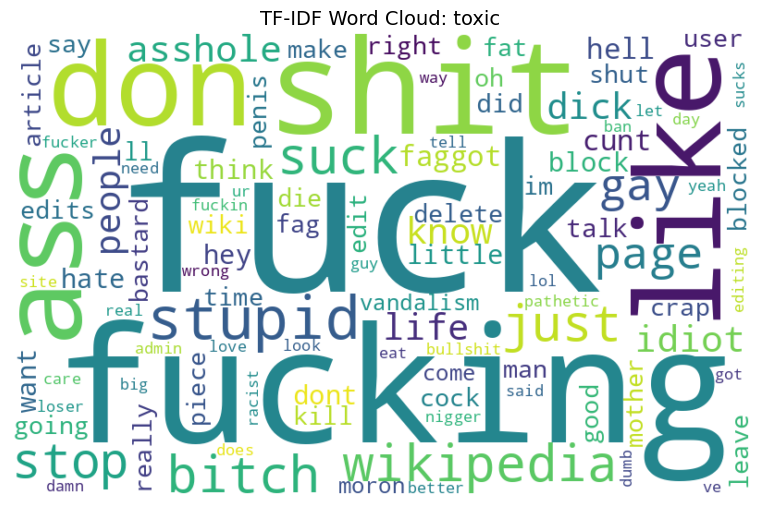

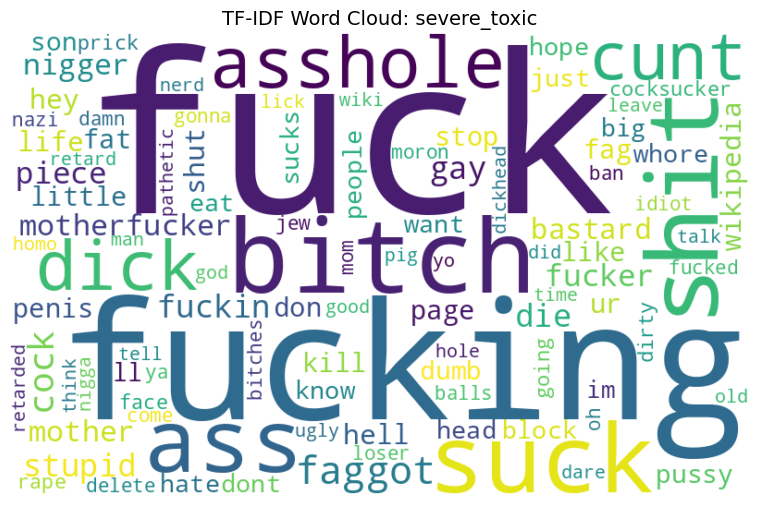

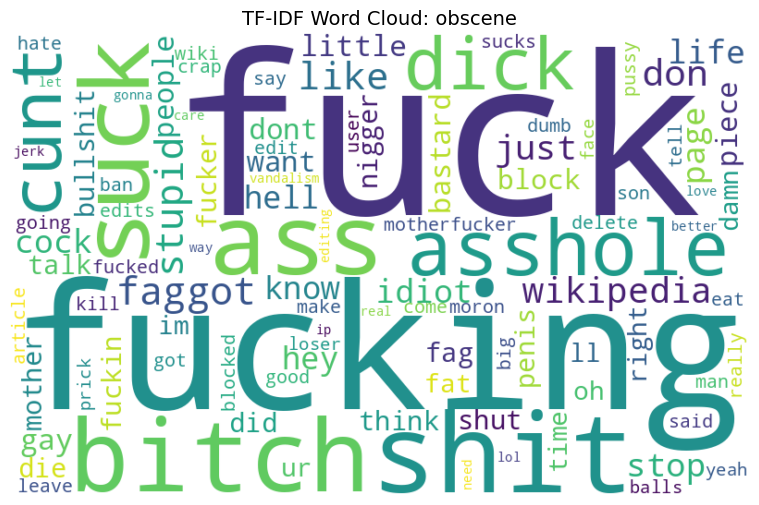

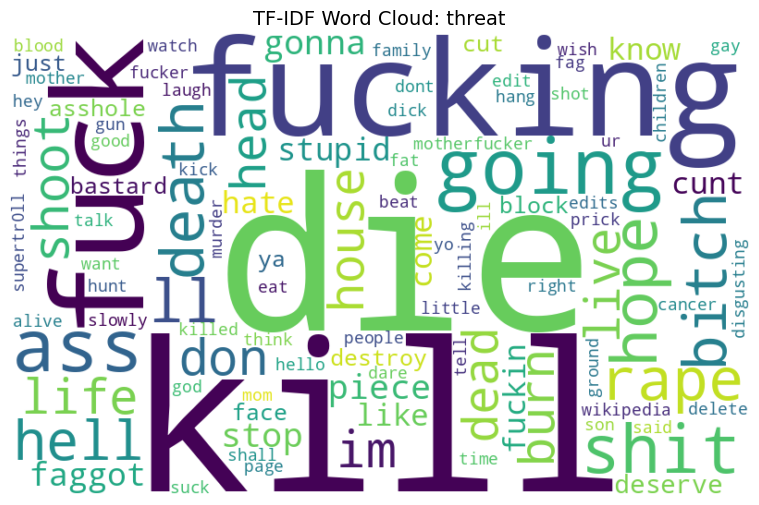

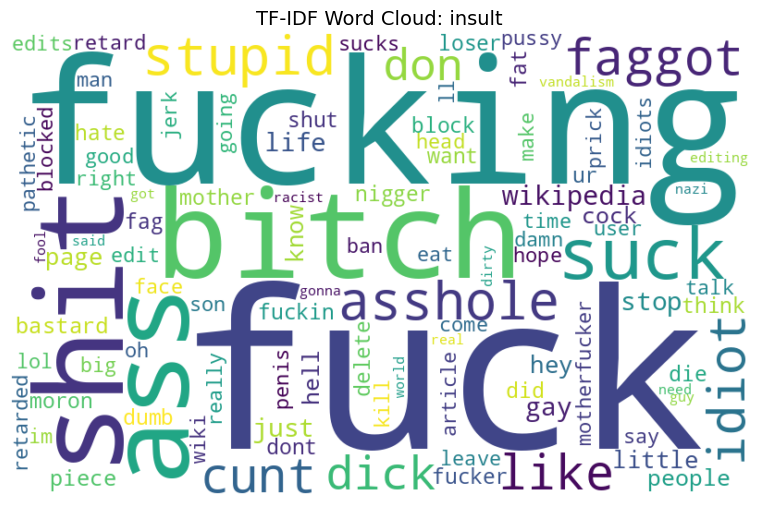

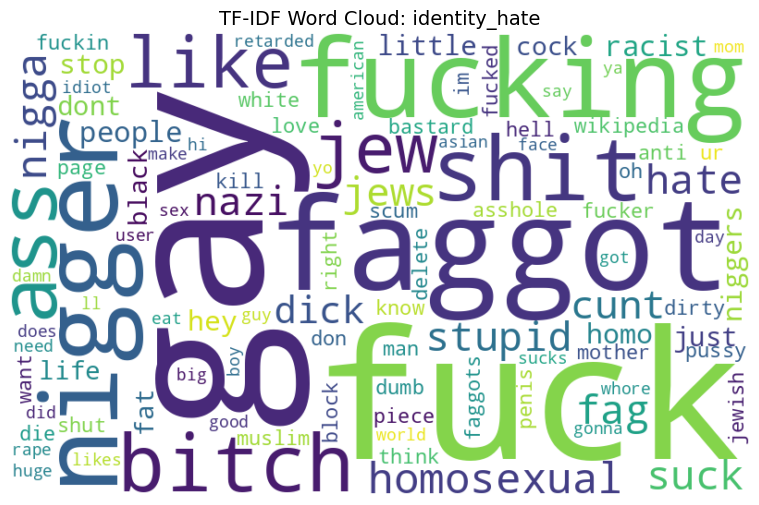

In [ ]:
# ================================================================
# VISUALIZZAZIONE WORD CLOUD
# ================================================================

text_column = "comment_text"

# Vettorizzazione TF-IDF
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X = vectorizer.fit_transform(df[text_column].fillna("").astype(str))
feature_names = np.array(vectorizer.get_feature_names_out())

for category in toxic_categories:
    mask = (df[category] == 1).values  # Conversione a numpy

    if mask.sum() == 0:
        continue

    # Media dei punteggi TF-IDF per la categoria
    category_tfidf = X[mask].mean(axis=0).A1

    # Dizionario parola -> peso
    word_weights = dict(zip(feature_names, category_tfidf))

    # Word Cloud
    wc = WordCloud(width=800, height=500, background_color="white",
                   max_words=100).generate_from_frequencies(word_weights)

    plt.figure(figsize=(10, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"TF-IDF Word Cloud: {category}", fontsize=14)
    plt.show()


In [ ]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious,num_labels,label_combination_string,num_toxic_categories
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,0,Non tossico,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,0,Non tossico,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,0,Non tossico,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,0,Non tossico,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,0,Non tossico,0


In [ ]:
df["label_combination_string"].unique()

array(['Non tossico', 'insult+obscene+severe_toxic+toxic', 'toxic',
       'identity_hate+insult+obscene+toxic', 'insult+obscene+toxic',
       'obscene+toxic', 'threat+toxic', 'insult+toxic',
       'identity_hate+insult+obscene+threat+toxic', 'insult', 'obscene',
       'obscene+severe_toxic+toxic', 'insult+obscene+threat+toxic',
       'identity_hate+insult+obscene+severe_toxic+toxic',
       'identity_hate+insult+obscene+severe_toxic+threat+toxic',
       'identity_hate+insult+toxic', 'identity_hate+toxic',
       'insult+obscene', 'identity_hate+obscene+severe_toxic+toxic',
       'insult+obscene+severe_toxic+threat+toxic', 'identity_hate',
       'identity_hate+obscene+toxic', 'threat',
       'identity_hate+insult+obscene', 'severe_toxic+toxic',
       'insult+severe_toxic+toxic', 'identity_hate+severe_toxic+toxic',
       'obscene+threat', 'insult+threat+toxic', 'identity_hate+insult',
       'obscene+severe_toxic+threat+toxic',
       'identity_hate+insult+severe_toxic+toxic',

In [ ]:
df.groupby("label_combination_string")["num_toxic_categories"].first().sort_values()

,num_toxic_categories
label_combination_string,
Non tossico,0
identity_hate,1
obscene,1
insult,1
toxic,1
threat,1
identity_hate+toxic,2
insult+obscene,2
insult+toxic,2


#2. **Implementazione del Modello**


In [ ]:
# ================================================================
# CONFIGURAZIONE
# ================================================================
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

MAX_NUM_WORDS = 40000
VAL_SIZE = 0.15
HOLDOUT_SIZE = 0.10
TEST_SIZE = 0.15

X = df['comment_text']  # TESTO ORIGINALE SENZA PULIZIA
Y = df[toxic_categories].values

##2.1 **Split del Dataset**



Separare il dataset in più partizioni (train, validation, holdout e test) è fondamentale per addestrare e valutare correttamente un modello, soprattutto in un problema multi-label come il filtro anti-hate. Questa pratica permette di addestrare, ottimizzare e valutare il modello in modo imparziale, garantendo che le prestazioni misurate riflettano la sua reale capacità di generalizzare su dati mai visti.

In particolare, ho introdotto un holdout set per ottimizzare le soglie di decisione per ciascuna etichetta: nei problemi multi-label infatti si lavora con probabilità e occorre fissare un cut-off per attivare un’etichetta. Se avessi ottimizzato le soglie sul validation set, avrei rischiato di introdurre data leakage e di overfittare il modello.

In [ ]:
# ================================================================
# SPLIT DEL DATASET
# ================================================================
def multi_label_split(X, Y, split_size, seed=SEED):
    """Split stratificato per multi-label"""
    indices = np.arange(len(X))
    np.random.seed(seed)
    permuted_indices = np.random.permutation(indices)
    X_perm = X.iloc[permuted_indices]
    Y_perm = Y[permuted_indices]
    strat_indices = np.arange(len(X_perm))
    splitter = IterativeStratification(
        n_splits=2,
        order=1,
        sample_distribution_per_fold=[split_size, 1.0 - split_size]
    )
    train_idx, split_idx = next(splitter.split(strat_indices, Y_perm))
    return (
        X_perm.iloc[train_idx], Y_perm[train_idx],
        X_perm.iloc[split_idx], Y_perm[split_idx]
    )

print("\n=== SPLIT DATASET (PRE-PULIZIA) ===")

# Test set
X_temp, Y_temp, X_test_raw, Y_test = multi_label_split(X, Y, TEST_SIZE, seed=SEED)

# Holdout set (per tuning soglie)
remaining_size = 1 - TEST_SIZE
holdout_relative = HOLDOUT_SIZE / remaining_size
X_train_val_raw, Y_train_val, X_holdout_raw, Y_holdout = multi_label_split(
    X_temp, Y_temp, holdout_relative, seed=SEED+1
)

# Train/Validation
remaining_size_2 = remaining_size - HOLDOUT_SIZE
val_relative = VAL_SIZE / remaining_size_2
X_train_raw, Y_train, X_val_raw, Y_val = multi_label_split(
    X_train_val_raw, Y_train_val, val_relative, seed=SEED+2
)

print(f"Train: {X_train_raw.shape[0]}")
print(f"Validation: {X_val_raw.shape[0]}")
print(f"Holdout: {X_holdout_raw.shape[0]}")
print(f"Test: {X_test_raw.shape[0]}")
print(f"Totale: {X_train_raw.shape[0] + X_val_raw.shape[0] + X_holdout_raw.shape[0] + X_test_raw.shape[0]}")



=== SPLIT DATASET (PRE-PULIZIA) ===
Train: 95741
Validation: 23936
Holdout: 15958
Test: 23936
Totale: 159571


##2.2 **Pre-proccessing del testo**

Le attività di preprocessing eseguono la pulizia del testo (rimozione di URL, HTML, punteggiatura, numeri e stopwords) separatamente per ogni split per evitare data leakage, e poi adattano il tokenizer solo sul train set calcolando anche la lunghezza massima delle sequenze per normalizzare i commenti in input al modello.

In [ ]:
# ================================================================
# PULIZIA DEL TESTO
# ================================================================
print("\n=== PULIZIA TESTO POST-SPLIT ===")

# Definisco stopwords e funzione pulizia
stop_words = set(stopwords.words('english'))
custom_stopwords = {} # Al momento non ho inserito stopwords custom
stop_words = stop_words.union(custom_stopwords)

def clean_text(text):
    """Pulizia del testo senza dipendenze da altri dataset"""

    # Espressioni regolari per pulire i testi:
    text = str(text).lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # URL
    text = re.sub(r'<.*?>', '', text)  # Tag HTML
    text = re.sub(r'[^\w\s]', '', text)  # Punteggiatura
    text = re.sub(r'\d+', '', text)  # Numeri
    text = re.sub(r'\s+', ' ', text).strip()  # Spazi multipli

    # Tokenizzazione e rimozione stopwords
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words and len(word) > 1]
    return ' '.join(words)

def apply_cleaning_post_split(X_train, X_val, X_holdout, X_test):
    """
    PULIZIA: Applica pulizia a ogni split separatamente
    Ogni operazione di pulizia è indipendente per non introdurre data leakage
    """
    print("Applicando pulizia a Train set...")
    X_train_clean = X_train.apply(clean_text)

    print("Applicando pulizia a Validation set...")
    X_val_clean = X_val.apply(clean_text)

    print("Applicando pulizia a Holdout set...")
    X_holdout_clean = X_holdout.apply(clean_text)

    print("Applicando pulizia a Test set...")
    X_test_clean = X_test.apply(clean_text)

    return X_train_clean, X_val_clean, X_holdout_clean, X_test_clean

# Applico la pulizia
X_train, X_val, X_holdout, X_test = apply_cleaning_post_split(
    X_train_raw, X_val_raw, X_holdout_raw, X_test_raw
)

print(" Pulizia completata per tutti i set")


=== PULIZIA TESTO POST-SPLIT ===
Applicando pulizia a Train set...
Applicando pulizia a Validation set...
Applicando pulizia a Holdout set...
Applicando pulizia a Test set...
 Pulizia completata per tutti i set


In [ ]:
# ================================================================
# TOKENIZER E PREPROCESSING (FIT SOLO SU TRAIN SET)
# ================================================================
print("\n=== PREPROCESSING ===")

# Analisi lunghezza commenti su train set
comment_lengths = X_train.apply(lambda x: len(str(x).split()))
MAX_SEQUENCE_LENGTH = int(np.percentile(comment_lengths, 95))
print(f"MAX_SEQUENCE_LENGTH: {MAX_SEQUENCE_LENGTH}")

# Fit tokenizer su train set
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
print(f"Vocab size: {len(tokenizer.word_index)}")


=== PREPROCESSING ===
MAX_SEQUENCE_LENGTH: 116
Vocab size: 158014


##2.3 **Bilanciamento delle Classi**

I dataset reali molto spesso sono sbilanciata proprio per la natura stessa del fenomeno che tracciano. Un dataset sbilanciamento può compromettere pesantemente il modo in cui un modello apprende e di conseguenza le sue performance:

1. Bias del modello verso le classi maggioritarie
2. Prestazioni scarse sulle classi minoritarie
3. Metriche di valutazione potenzialmente fuorvianti


**Il codice seguente riequilibra il training set riducendo i non tossici sovrarappresentati e replicando le combinazioni tossiche rare**. In questo modo il training set diventa più bilanciato, con meno bias verso i commenti non tossici. **Il modello ha così più probabilità di imparare anche i pattern meno frequenti che riguardano combinazioni tossiche rare**. In particolare il codice:

- Conta le combinazioni di etichette: per ogni commento crea una stringa che rappresenta le etichette attive, poi calcola quante volte appare ciascuna combinazione.

- Under-sampling della classe non tossica: se i commenti senza etichette superano il 60% del dataset, ne mantiene solo una parte per evitare che dominino il training.

- Over-sampling delle combinazioni rare: se una combinazione ha meno di un numero minimo di esempi (almeno 100 o 0,5% del dataset), ne crea delle copie (sampling con sostituzione) per portarle al livello minimo.

- Ricomposizione: unisce i dati riequilibrati, li mescola e ricostruisce le etichette multi-label.


In [ ]:
# ================================================================
# BILANCIAMENTO DEL TRAINING SET
# ================================================================
def analyze_balancing(Y_data, dataset_name, category_names):
    print(f"\n--- Analisi Bilanciamento: {dataset_name} ---")
    num_samples = Y_data.shape[0]
    label_counts = np.sum(Y_data, axis=0)
    for name, count in zip(category_names, label_counts):
        print(f"  {name}: {count} ({count/num_samples*100:.2f}%)")

def balance_multilabel_dataset(X_train, Y_train, label_columns, rare_threshold=0.5):
    """Bilanciamento"""
    if isinstance(X_train, pd.Series):
        X_train_df = X_train.to_frame(name='comment_text')
    else:
        X_train_df = X_train.copy()

    Y_df = pd.DataFrame(Y_train, columns=label_columns)
    Y_df['label_combo'] = Y_df.astype(int).astype(str).agg(''.join, axis=1)
    combined_df = pd.concat([X_train_df.reset_index(drop=True), Y_df['label_combo']], axis=1)

    class_counts = combined_df['label_combo'].value_counts()
    total_samples = len(combined_df)

    # Logica di bilanciamento
    non_toxic_class = "0" * len(label_columns)
    min_samples_per_class = max(100, int(0.005 * total_samples))
    max_non_toxic = int(0.6 * total_samples)

    resampled_dfs = []

    for label_combo, count in class_counts.items():
        df_class = combined_df[combined_df['label_combo'] == label_combo]

        if label_combo == non_toxic_class and len(df_class) > max_non_toxic:
            df_class = resample(df_class, replace=False, n_samples=max_non_toxic, random_state=SEED)
            print(f"Under-sampling '{label_combo}': {count} -> {max_non_toxic}")
        elif len(df_class) < min_samples_per_class:
            target_size = min_samples_per_class
            df_class = resample(df_class, replace=True, n_samples=target_size, random_state=SEED)
            print(f"Over-sampling '{label_combo}': {count} -> {target_size}")

        resampled_dfs.append(df_class)

    balanced_df = pd.concat(resampled_dfs).sample(frac=1, random_state=SEED).reset_index(drop=True)
    X_balanced = balanced_df['comment_text']
    Y_balanced = balanced_df['label_combo'].apply(lambda x: pd.Series(list(x))).astype(int).values

    analyze_balancing(Y_train, "Training Originale", label_columns)
    analyze_balancing(Y_balanced, "Training Bilanciato", label_columns)

    return X_balanced.reset_index(drop=True), Y_balanced

# Bilanciamento su train set
X_train_balanced, Y_train_balanced = balance_multilabel_dataset(
    X_train, Y_train, label_columns=toxic_categories
)

# Tokenizzazione di tutti i set
X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train_balanced),
                            maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")
X_val_pad = pad_sequences(tokenizer.texts_to_sequences(X_val),
                          maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")
X_holdout_pad = pad_sequences(tokenizer.texts_to_sequences(X_holdout),
                              maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")
X_test_pad = pad_sequences(tokenizer.texts_to_sequences(X_test),
                           maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")

Under-sampling '000000': 85934 -> 57444
Over-sampling '101011': 357 -> 478
Over-sampling '000010': 222 -> 478
Over-sampling '001000': 198 -> 478
Over-sampling '111011': 153 -> 478
Over-sampling '001010': 121 -> 478
Over-sampling '111000': 102 -> 478
Over-sampling '100011': 88 -> 478
Over-sampling '100001': 86 -> 478
Over-sampling '101110': 75 -> 478
Over-sampling '100100': 61 -> 478
Over-sampling '111110': 46 -> 478
Over-sampling '000001': 41 -> 478
Over-sampling '101111': 34 -> 478
Over-sampling '000011': 22 -> 478
Over-sampling '110000': 22 -> 478
Over-sampling '111111': 18 -> 478
Over-sampling '101001': 16 -> 478
Over-sampling '000100': 12 -> 478
Over-sampling '110100': 10 -> 478
Over-sampling '100110': 9 -> 478
Over-sampling '001011': 8 -> 478
Over-sampling '101100': 7 -> 478
Over-sampling '111001': 6 -> 478
Over-sampling '110010': 6 -> 478
Over-sampling '110011': 4 -> 478
Over-sampling '100101': 3 -> 478
Over-sampling '111100': 2 -> 478
Over-sampling '000110': 2 -> 478
Over-sampli

##2.4 **Class Weight e Loss Pesata**

Vengono calcolati pesi per ciascuna classe, inversamente proporzionali alla loro frequenza, e utilizzati in una loss function personalizzata (binary crossentropy pesata). In questo modo si compensa lo sbilanciamento del dataset, permettendo al modello di considerare con pari importanza anche le categorie meno rappresentate.

In [ ]:
# ================================================================
# CLASS WEIGHTS + LOSS PESATA
# ================================================================
def compute_class_weights(Y):
    n_samples, n_classes = Y.shape
    class_counts = np.sum(Y, axis=0)
    class_freq = class_counts / n_samples
    weights = 1.0 / (class_freq + 1e-6)
    weights /= np.sum(weights) * n_classes
    return weights

class_weights = compute_class_weights(Y_train_balanced)
print(f"\nPesi per classe: {dict(zip(toxic_categories, class_weights))}")

def weighted_binary_crossentropy(class_weights):
    class_weights = tf.constant(class_weights, dtype=tf.float32)
    class_weights = tf.reshape(class_weights, [1, -1])

    def loss_fn(y_true, y_pred):
        bce_per_class = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        weighted_bce = bce_per_class * class_weights
        return tf.reduce_mean(weighted_bce, axis=-1)
    return loss_fn


Pesi per classe: {'toxic': np.float64(0.013823548434877155), 'severe_toxic': np.float64(0.041542206192226934), 'obscene': np.float64(0.021869352013324305), 'threat': np.float64(0.03445381713550448), 'insult': np.float64(0.022550600488399165), 'identity_hate': np.float64(0.03242714240233463)}


##2.5  **Callback Personalizzata con Early Stopping Basata su Weighted F1**

Di seguito si definisce una callback Keras che calcola il **F1-score pesato inversamente alla frequenza delle classi** alla fine di ogni epoca, salva il modello migliore in base a questa metrica e applica early stopping se il punteggio non migliora per un numero definito di epoche, prevenendo overfitting.

Ho deciso di creare un F1 score pesato inversamente perché:

- Compensa lo sbilanciamento del dataset: le classi rare ricevono un peso maggiore, così il modello viene valutato in modo più severo sulla loro capacità di riconoscerle.

- Evita metriche fuorvianti: in un dataset sbilanciato, un modello che ignora le classi minoritarie potrebbe comunque ottenere un F1 elevato se le classi maggioritarie dominano la metrica; il peso inverso bilancia questo effetto.

- Favorisce modelli più equi: incoraggia il modello a migliorare anche sulle categorie meno rappresentate, il che è particolarmente importante in scenari come il nostro realativi all'hate speech detection.

In [ ]:
# ================================================================
# CALLBACK F1 INVERSAMENE PESATO
# ================================================================
def weighted_inverse_f1(y_true, y_pred, eps=1e-6):
    n_samples, n_classes = y_true.shape
    class_counts = np.sum(y_true, axis=0)
    class_freq = class_counts / (n_samples + eps)
    inv_weights = 1.0 / (class_freq + eps)
    inv_weights /= np.sum(inv_weights)
    f1_per_class = [f1_score(y_true[:, i], y_pred[:, i], zero_division=0)
                    for i in range(n_classes)]
    return np.sum(np.array(f1_per_class) * inv_weights)

class WeightedF1CheckpointAndEarlyStop(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val, filepath, threshold=0.5, batch_size=128,
                 patience=3, verbose=1):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.filepath = filepath
        self.threshold = threshold
        self.batch_size = batch_size
        self.best_f1 = -np.inf
        self.patience = patience
        self.wait = 0
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs=None):
        y_val_probs = self.model.predict(self.X_val, batch_size=self.batch_size, verbose=0)
        y_val_pred = (y_val_probs >= self.threshold).astype(int)
        f1_weighted = weighted_inverse_f1(self.y_val, y_val_pred)

        if logs is not None:
            logs['val_f1_weighted'] = f1_weighted

        if self.verbose:
            print(f"\nEpoch {epoch+1}: Weighted F1 = {f1_weighted:.4f} (best: {self.best_f1:.4f})")

        if f1_weighted > self.best_f1:
            self.best_f1 = f1_weighted
            self.model.save(self.filepath)
            self.wait = 0
            if self.verbose:
                print(f"Nuovo best F1: salvato in {self.filepath}")
        else:
            self.wait += 1
            if self.wait >= self.patience:
                if self.verbose:
                    print(f"⏹ Early stopping dopo {self.patience} epoche senza miglioramenti")
                self.model.stop_training = True

##2.6 **Definizione del Modello Ibrido CNN + BiGRU con Attention**

Il codice definisce e compila un modello neurale che combina **convoluzioni 1D**, **strato ricorrente bidirezionale GRU e meccanismo di attention** per catturare sia pattern locali che dipendenze contestuali nei testi, producendo probabilità multi-label con attivazione sigmoid e loss pesata per gestire lo sbilanciamento delle classi.

In [ ]:
# ================================================================
# MODELLO CNN+BiGRU+ATTENTION
# ================================================================
def create_cnn_rnn_model(vocab_size, max_length, embedding_dim=128):
    inputs = Input(shape=(max_length,))
    embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                          input_length=max_length,
                          embeddings_regularizer=tf.keras.regularizers.l2(1e-5))(inputs)

    conv1 = Conv1D(64, 3, activation='relu', padding='same',
                   kernel_regularizer=tf.keras.regularizers.l2(1e-5))(embedding)
    conv1 = BatchNormalization()(conv1)
    drop1 = Dropout(0.2)(conv1)

    conv2 = Conv1D(128, 4, activation='relu', padding='same',
                   kernel_regularizer=tf.keras.regularizers.l2(1e-5))(drop1)
    conv2 = BatchNormalization()(conv2)
    drop2 = Dropout(0.2)(conv2)

    gru = Bidirectional(GRU(64, return_sequences=True,
                            kernel_regularizer=tf.keras.regularizers.l2(1e-5),
                            recurrent_regularizer=tf.keras.regularizers.l2(1e-5)))(drop2)
    gru = BatchNormalization()(gru)
    drop3 = Dropout(0.2)(gru)

    attention = tf.keras.layers.Attention()([drop3, drop3])
    cnn_features = GlobalMaxPooling1D()(drop2)
    rnn_features = GlobalMaxPooling1D()(drop3)
    attention_features = GlobalMaxPooling1D()(attention)
    combined = concatenate([cnn_features, rnn_features, attention_features])

    dense1 = Dense(64, activation='relu',
                   kernel_regularizer=tf.keras.regularizers.l2(1e-5))(combined)
    dense1 = BatchNormalization()(dense1)
    drop4 = Dropout(0.3)(dense1)

    outputs = Dense(len(toxic_categories), activation='sigmoid')(drop4)
    return Model(inputs=inputs, outputs=outputs)

model = create_cnn_rnn_model(MAX_NUM_WORDS, MAX_SEQUENCE_LENGTH)
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=weighted_binary_crossentropy(class_weights),
    metrics=[AUC(name='auc_roc'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.BinaryAccuracy(name='accuracy')]
)


#3. **Addestramento e Visualizzazione delle Metriche**


##3.1 **Training del Modello con Early Stopping e Riduzione Dinamica del Learning Rate**

Di seguito viene allenato il modello utilizzando un callback personalizzato che salva i pesi migliori e interrompe l’addestramento se il weighted F1 non migliora; inoltre implementa un meccanismo di riduzione automatica del learning rate per favorire una convergenza stabile.

In [ ]:
# ================================================================
# TRAINING CON CALLBACKS COERENTI
# ================================================================
print("\n=== TRAINING ===")

ckpt_path = "cnn_rnn_best.keras"
weighted_f1_callback = WeightedF1CheckpointAndEarlyStop(
    X_val=X_val_pad,
    y_val=Y_val,
    filepath=ckpt_path,
    threshold=0.5,
    patience=3,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_f1_weighted',
    mode='max',
    factor=0.2,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    X_train_pad, Y_train_balanced,
    validation_data=(X_val_pad, Y_val),
    epochs=20,
    batch_size=128,
    callbacks=[weighted_f1_callback, reduce_lr],
    verbose=1
)


=== TRAINING ===
Epoch 1/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.8311 - auc_roc: 0.8520 - loss: 0.0279 - precision: 0.4721 - recall: 0.6826
Epoch 1: Weighted F1 = 0.0293 (best: -inf)
Nuovo best F1: salvato in cnn_rnn_best.keras
639/639 ━━━━━━━━━━━━━━━━━━━━ 684s 1s/step - accuracy: 0.8313 - auc_roc: 0.8521 - loss: 0.0278 - precision: 0.4724 - recall: 0.6827 - val_accuracy: 0.8738 - val_auc_roc: 0.7706 - val_loss: 0.0132 - val_precision: 0.1043 - val_recall: 0.3224 - val_f1_weighted: 0.0293 - learning_rate: 0.0010
Epoch 2/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.9640 - auc_roc: 0.9844 - loss: 0.0059 - precision: 0.8957 - recall: 0.8227
Epoch 2: Weighted F1 = 0.1637 (best: 0.0293)
Nuovo best F1: salvato in cnn_rnn_best.keras
639/639 ━━━━━━━━━━━━━━━━━━━━ 672s 1s/step - accuracy: 0.9640 - auc_roc: 0.9844 - loss: 0.0059 - precision: 0.8957 - recall: 0.8227 - val_accuracy: 0.9754 - val_auc_roc: 0.9642 - val_loss: 0.0043 - val_precision: 0.9289 - val_rec

##3.2 **Visualizzazione delle Metriche di Addestramento e Validazione**

Il codice definisce una funzione che, usando l’oggetto history, traccia in sottografi l’andamento di tutte le metriche monitorate — **loss, AUC (ROC), precision, recall e accuracy** — sia per il training che per la validation, facilitando l’analisi della convergenza del modello e l’individuazione di overfitting o underfitting.

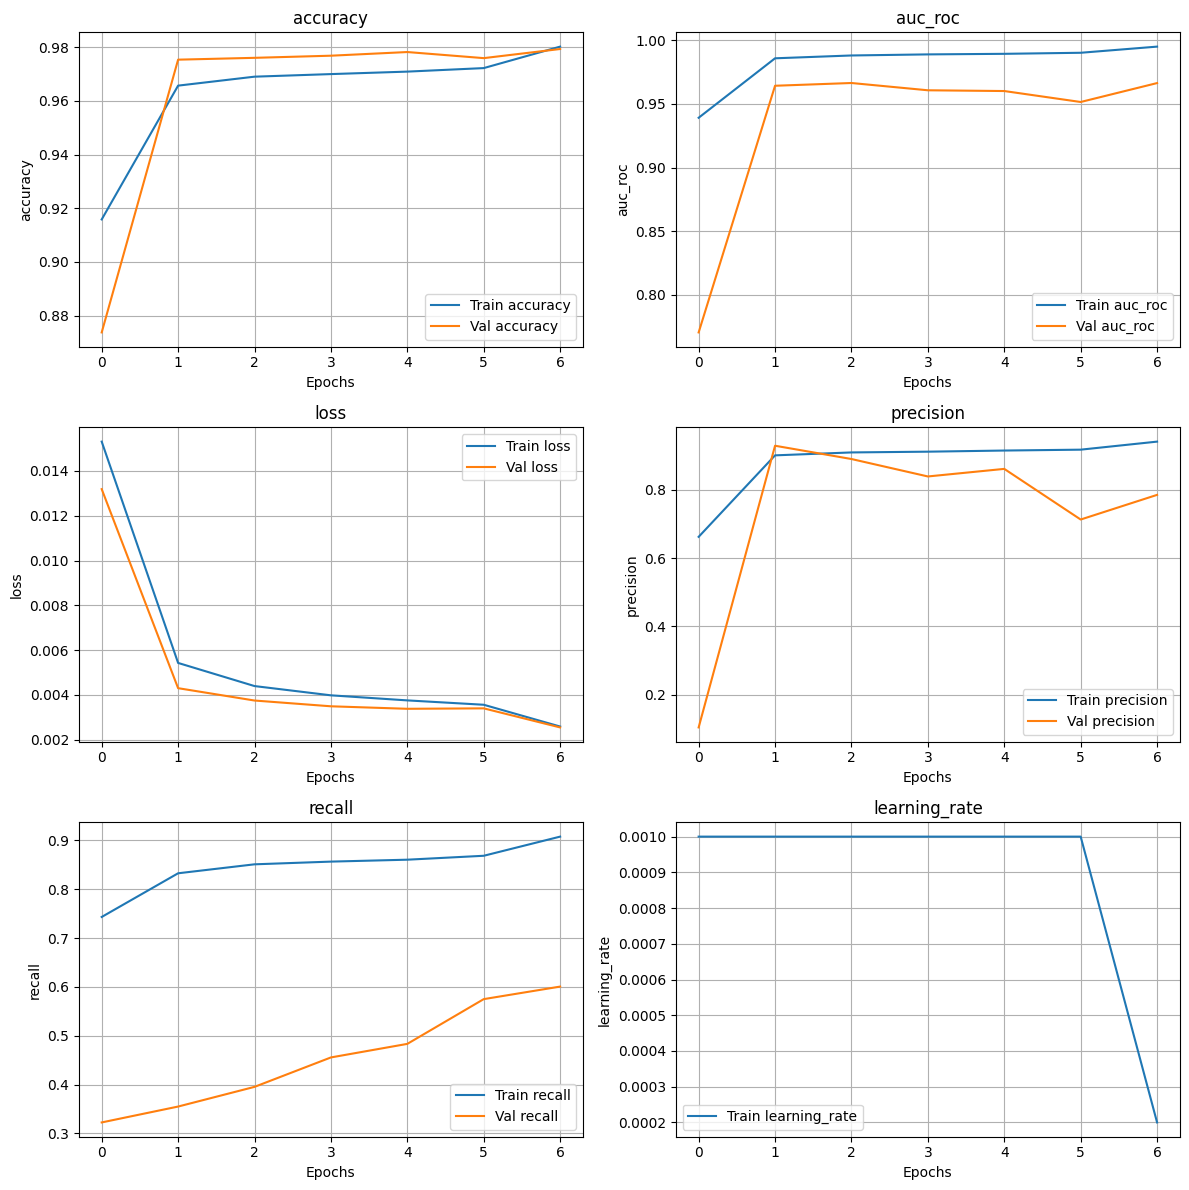

In [ ]:
# ================================================================
# VISUALIZZAZIONE METRICHE DI TRAINING
# ================================================================

import matplotlib.pyplot as plt
import math

def plot_metrics(history):
    """Plot delle metriche del training e validation"""
    metrics = [m for m in history.history.keys() if not m.startswith('val_')]
    n_metrics = len(metrics)
    n_cols = 2
    n_rows = math.ceil(n_metrics / n_cols)

    plt.figure(figsize=(n_cols*6, n_rows*4))

    for i, metric in enumerate(metrics):
        plt.subplot(n_rows, n_cols, i+1)
        plt.plot(history.history[metric], label=f"Train {metric}")
        if f"val_{metric}" in history.history:
            plt.plot(history.history[f"val_{metric}"], label=f"Val {metric}")
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.title(metric)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_metrics(history)

#4. **Valutazione finale e Analisi dei Risultati**


##4.1 **Ricaricamento del modello con i Migliori Pesi**

Questo codice ricarica i pesi salvati con le migliori prestazioni dal file di checkpoint, ricompila il modello con la stessa loss e metriche.

In [ ]:
# ================================================================
# RICARICA MIGLIORI PESI PRIMA DELLE PREDIZIONI
# ================================================================
print("\n=== RICARICA MIGLIORI PESI ===")

try:
    model = load_model(ckpt_path, compile=False)
    print(f"Ricaricati i migliori pesi da {ckpt_path}")

    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss=weighted_binary_crossentropy(class_weights),
        metrics=[AUC(name='auc_roc'),
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall'),
                 tf.keras.metrics.BinaryAccuracy(name='accuracy')]
    )
except Exception as e:
    print(f"Errore nel caricare i pesi: {e}")
    print("Continuo con il modello corrente...")


=== RICARICA MIGLIORI PESI ===
Ricaricati i migliori pesi da cnn_rnn_best.keras


##4.2 **Tuning delle soglie di classificazione su Holdout Set con correzione per classi rare**

Ora viene calcola la soglia di probabilità ottimale per ciascuna classe massimizzando il F1-score sull’holdout set e abbassando ulteriormente le soglie delle classi più rare (threat, identity_hate) per migliorare il recall su queste categorie sottorappresentate.

In [ ]:
# ================================================================
# TUNING SOGLIE SU HOLDOUT SET
# ================================================================
def find_optimal_thresholds_per_class(y_true, y_probs, step=0.01):
    """Trova soglie ottimali per ogni classe"""
    n_classes = y_true.shape[1]
    thresholds = []

    print(f"Tuning soglie su {len(y_true)} campioni con step={step}")

    for i in range(n_classes):
        best_thr, best_f1 = 0.5, -1
        for thr in np.arange(0.01, 0.91, step):
            preds = (y_probs[:, i] >= thr).astype(int)
            f1 = f1_score(y_true[:, i], preds, zero_division=0)
            if f1 > best_f1:
                best_f1, best_thr = f1, thr

        thresholds.append(best_thr)
        print(f"  {toxic_categories[i]}: soglia={best_thr:.3f}, F1={best_f1:.3f}")

    return thresholds

print("\n=== TUNING SOGLIE SU HOLDOUT SET ===")

holdout_probs = model.predict(X_holdout_pad, batch_size=128, verbose=1)
optimal_thresholds = find_optimal_thresholds_per_class(Y_holdout, holdout_probs, step=0.02)

print("\n=== ABBASSAMENTO SOGLIE CLASSI RARE ===")
RARE_CLASSES = ["threat", "identity_hate"]
LOWER_FACTOR = 0.8

for i, cat in enumerate(toxic_categories):
    if cat in RARE_CLASSES:
        old_thr = optimal_thresholds[i]
        optimal_thresholds[i] = max(0.01, old_thr * LOWER_FACTOR)
        print(f"  {cat}: {old_thr:.3f} -> {optimal_thresholds[i]:.3f}")


=== TUNING SOGLIE SU HOLDOUT SET ===
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 214ms/step
Tuning soglie su 15958 campioni con step=0.02
  toxic: soglia=0.170, F1=0.744
  severe_toxic: soglia=0.470, F1=0.448
  obscene: soglia=0.150, F1=0.783
  threat: soglia=0.370, F1=0.554
  insult: soglia=0.050, F1=0.709
  identity_hate: soglia=0.130, F1=0.432

=== ABBASSAMENTO SOGLIE CLASSI RARE ===
  threat: 0.370 -> 0.296
  identity_hate: 0.130 -> 0.104


##4.3 **Valutazione Finale sul Test Set**

Il codice generate le predizioni sul test set usando le soglie ottimizzate.

*Analisi dei Risultati:*


- **toxic**: precision 0.80, recall 0.72, F1=0.76 → buon compromesso, anche se qualche falso negativo (recall < precision).

- **obscene**: ottimo risultato, F1=0.80, recall molto alto (0.83) → il modello è bravo a rilevarla.

- **insult**: buono (F1=0.70), recall alto → intercetta la maggior parte dei casi.

- **severe_toxic**: F1=0.39 → modello debole, recall 0.44 (molti falsi negativi).

- **threat**: F1=0.34 → classe difficile, recall basso (0.29), il modello perde molti casi reali.

- **identity_hate**: F1=0.40 → simile a severe_toxic, debole ma leggermente meglio in recall (0.37).


*Metriche globali:*

micro avg F1 = 0.72: buona performance complessiva, tiene conto del support (quindi dominata dalle classi più frequenti).

macro avg F1 = 0.56: nonostate il pesante ribilanciamento si evidenzia che le classi rare hanno performance più basse

weighted avg F1 = 0.72: molto vicino alla micro avg, il modello è efficace sulle classi più rappresentate, ma resta il problema di recall per le categorie rare.

In [ ]:
# ================================================================
# VALUTAZIONE FINALE SU TEST SET
# ================================================================
print("\n=== VALUTAZIONE FINALE SU TEST SET ===")

test_probs = model.predict(X_test_pad, batch_size=128, verbose=1)

# Applica soglie ottimizzate
test_preds = np.zeros_like(test_probs, dtype=int)
for i, thr in enumerate(optimal_thresholds):
    test_preds[:, i] = (test_probs[:, i] >= thr).astype(int)

print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(Y_test, test_preds, target_names=toxic_categories, zero_division=0))

# Metriche aggiuntive
test_f1_weighted = weighted_inverse_f1(Y_test, test_preds)
print(f"\nWeighted Inverse F1 su Test: {test_f1_weighted:.4f}")


=== VALUTAZIONE FINALE SU TEST SET ===
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 220ms/step

--- CLASSIFICATION REPORT ---
               precision    recall  f1-score   support

        toxic       0.80      0.72      0.76      2294
 severe_toxic       0.36      0.44      0.39       235
      obscene       0.77      0.83      0.80      1267
       threat       0.40      0.29      0.34        72
       insult       0.67      0.74      0.70      1182
identity_hate       0.43      0.37      0.40       211

    micro avg       0.72      0.72      0.72      5261
    macro avg       0.57      0.57      0.56      5261
 weighted avg       0.72      0.72      0.72      5261
  samples avg       0.06      0.06      0.06      5261


Weighted Inverse F1 su Test: 0.3923


##4.4 **Confronto tra soglie di default e soglie ottimizzate**

Di seguito vencono confrontate le prestazioni del modello usando la soglia standard di 0.5 con quelle ottenute tramite soglie ottimizzate per classe, mostrando un miglioramento del 18.3% nel weighted F1 e riportando le soglie finali adottate per ciascuna categoria.

In [ ]:
# ================================================================
# CONFRONTO SOGLIE DEFAULT vs OTTIMIZZATE
# ================================================================
print("\n=== CONFRONTO SOGLIE ===")

test_preds_default = (test_probs >= 0.5).astype(int)
f1_default = weighted_inverse_f1(Y_test, test_preds_default)

print(f"F1 pesato con soglie 0.5: {f1_default:.4f}")
print(f"F1 pesato con soglie ottimizzate: {test_f1_weighted:.4f}")
print(f"Miglioramento: {((test_f1_weighted / f1_default) - 1) * 100:.2f}%")

print(f"\nSoglie finali utilizzate:")
for cat, thr in zip(toxic_categories, optimal_thresholds):
    print(f"  {cat}: {thr:.3f}")


=== CONFRONTO SOGLIE ===
F1 pesato con soglie 0.5: 0.3316
F1 pesato con soglie ottimizzate: 0.3923
Miglioramento: 18.30%

Soglie finali utilizzate:
  toxic: 0.170
  severe_toxic: 0.470
  obscene: 0.150
  threat: 0.296
  insult: 0.050
  identity_hate: 0.104


##4.5  **Visualizzazione delle Matrici di Confusione per ciascuna classe**

Vengono calcolati pesi per ciascuna classe, inversamente proporzionali alla loro frequenza, e utilizzati in una loss function personalizzata (binary crossentropy pesata). In questo modo si compensa lo sbilanciamento del dataset, permettendo al modello di considerare con pari importanza anche le categorie meno rappresentate.

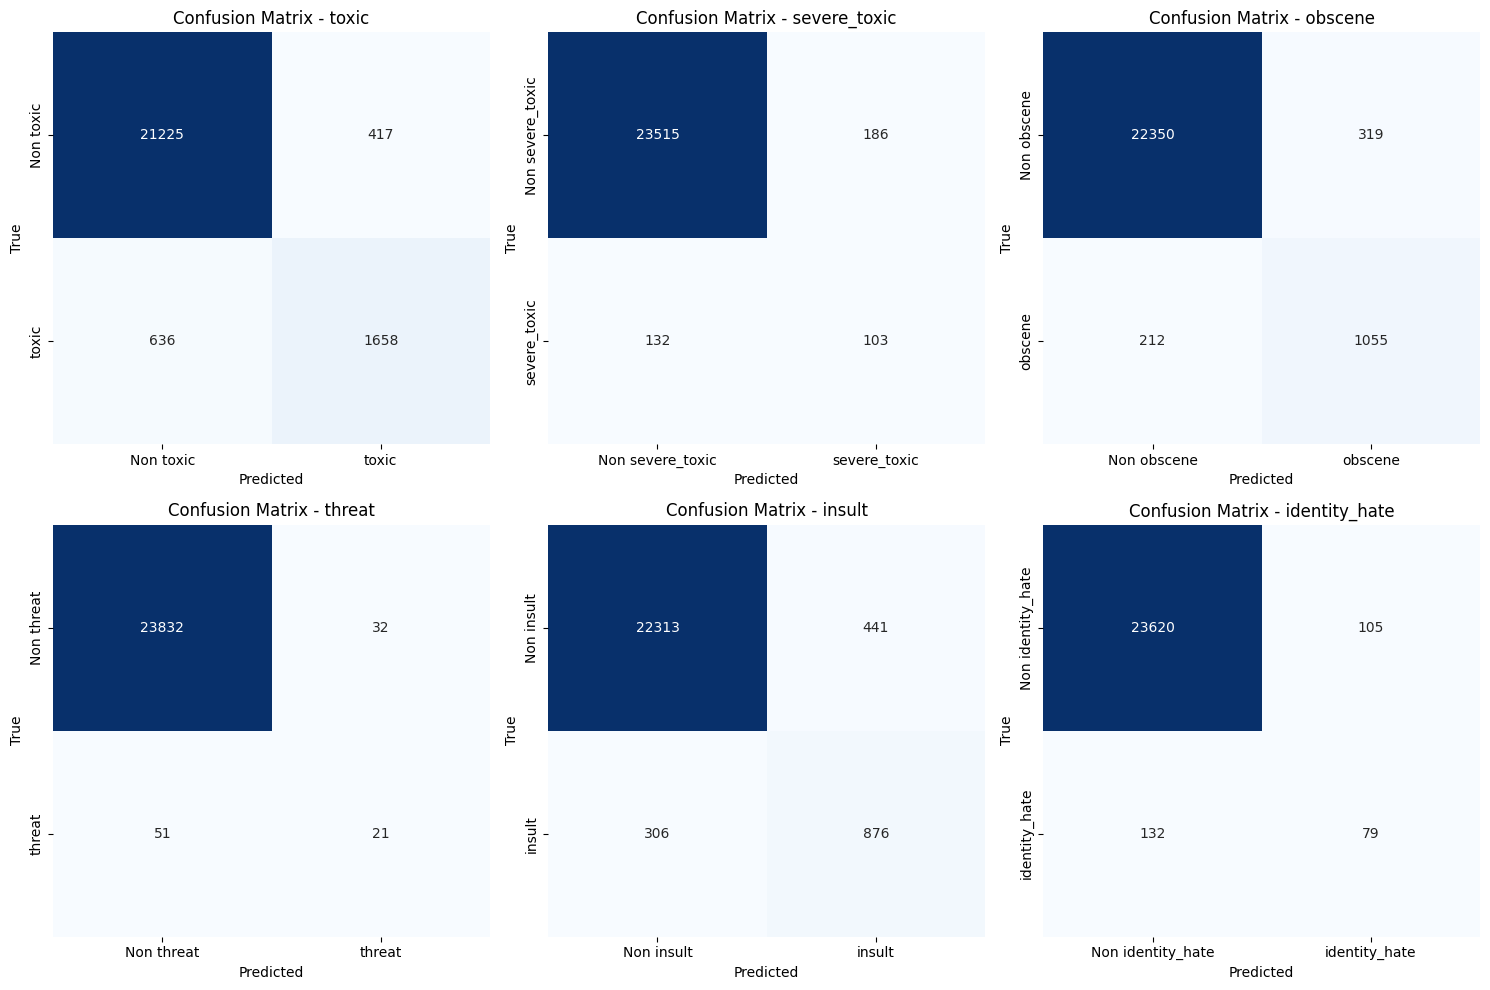

In [ ]:
# ================================================================
# MATRICE DI CONFUSIONE
# ================================================================
def plot_confusion_matrices(y_true_all, y_pred_all, labels, n_cols=3):
    n_classes = len(labels)
    n_rows = int(np.ceil(n_classes / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))

    if n_rows == 1:
        axes = [axes]

    for i, label in enumerate(labels):
        row, col = divmod(i, n_cols)
        ax = axes[row][col] if n_rows > 1 else axes[col]

        cm = confusion_matrix(y_true_all[:, i], y_pred_all[:, i])
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                    xticklabels=["Non " + label, label],
                    yticklabels=["Non " + label, label], ax=ax)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        ax.set_title(f"Confusion Matrix - {label}")

    # Hide empty subplots
    for i in range(n_classes, n_rows * n_cols):
        row, col = divmod(i, n_cols)
        ax = axes[row][col] if n_rows > 1 else axes[col]
        ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_confusion_matrices(Y_test, test_preds, toxic_categories, n_cols=3)

##4.6 **Analisi Dettagliata delle Matrici di Confusione - Classificazione Tossicità**

L'analisi delle sei matrici di confusione rivela un pattern distintivo: il modello presenta performance eterogenee fortemente correlate alla frequenza delle classi nel dataset, con prestazioni eccellenti per le classi comuni e significative difficoltà per quelle rare. Tuttavia, l'implementazione adottata include diverse tecniche avanate che mitigano in parte queste criticità.

---

### **Analisi Quantitativa per Classe**

#### **Toxic - Performance Buone**
- **Veri Positivi:** 1,658 | **Falsi Positivi:** 417 | **Falsi Negativi:** 636
- **Recall:** 72.3% | **Precision:** 79.9%
- **Valutazione:** Buon bilanciamento tra precision e recall. Il modello identifica correttamente oltre 7 commenti tossici su 10, con un tasso di falsi positivi contenuto.

---

#### **Severe_toxic - Performance Critiche**
- **Veri Positivi:** 103 | **Falsi Positivi:** 186 | **Falsi Negativi:** 132
- **Recall:** 43.8% | **Precision:** 35.6%
- **Valutazione:** Classe problematica nonostante l'over-sampling e il class weighting implementati. La bassa precision indica confusione semantica persistente con altre categorie.

---

#### **Obscene - Performance Ottime**
- **Veri Positivi:** 1,055 | **Falsi Positivi:** 319 | **Falsi Negativi:** 212
- **Recall:** 83.3% | **Precision:** 76.8%
- **Valutazione:** Migliore performance complessiva. Eccellente recall con precision accettabile, dimostrando l'efficacia dell'approccio per categorie con pattern linguistici distintivi.

---

#### **Threat - Performance Critiche**
- **Veri Positivi:** 21 | **Falsi Positivi:** 32 | **Falsi Negativi:** 51
- **Recall:** 29.2% | **Precision:** 39.6%
- **Valutazione:** Classe critica che rimane problematica nonostante threshold ottimizzato e abbassamento specifico per classi rare. La scarsità estrema dei dati (72 esempi totali) limita l'apprendimento anche con tecniche avanzate.

---

#### **Insult - Performance Discrete**
- **Veri Positivi:** 876 | **Falsi Positivi:** 441 | **Falsi Negativi:** 306
- **Recall:** 74.1% | **Precision:** 66.5%
- **Valutazione:** Performance equilibrate che beneficiano del bilanciamento del dataset. Il numero elevato di falsi positivi indica sovrapposizioni semantiche con "toxic" non completamente risolte dall'architettura CNN+BiGRU.

---

#### **Identity_hate - Performance Critiche**
- **Veri Positivi:** 79 | **Falsi Positivi:** 105 | **Falsi Negativi:** 132
- **Recall:** 37.4% | **Precision:** 42.9%
- **Valutazione:** Classe problematica per applicazioni anti-discriminazione nonostante strategie di mitigazione. La soglia ottimizzata (abbassata dell'80%) migliora il recall ma rimane insufficiente.



#5. **Conclusioni e Prospettive Future**


---



###5.1 **Strategie di Mitigazione Adottate**
Il codice implementa un approccio metodologico che include multiple strategie di ottimizzazione.

#### 1. **Split Stratificato Multi-Label**
- Utilizzo di IterativeStratification per preservare la distribuzione delle combinazioni di label
- Separazione rigorosa di train/validation/holdout/test per validation robusta

#### 2. **Bilanciamento Sofisticato**
- Over-sampling delle classi rare fino a soglie minime definite dinamicamente
- Under-sampling della classe dominante (non-tossico) per ridurre lo sbilanciamento
- Analisi delle combinazioni di label per bilanciamento più granulare

#### 3. **Architettura Ibrida CNN+BiGRU+Attention**
- Estrazione di feature a più livelli: locali, globali e contestuali
- Regolarizzazione L2, BatchNormalization e Dropout per prevenire overfitting
- Concatenazione di feature diverse per rappresentazione semantica più ricca

#### 4. **Loss Function Personalizzata**
- Weighted binary crossentropy con pesi calcolati su frequenze inverse delle classi
- Penalizzazione differenziata per classe basata su distribuzione dei dati
- Ottimizzazione mirata per classi rare durante il training

#### 5. **Threshold Optimization per classe**
- Tuning individuale su holdout set dedicato con griglia di valori
- Abbassamento specifico per threat e identity_hate tramite fattore moltiplicativo
- Ottimizzazione basata su F1 score per singola classe con ricerca esaustiva

---

###5.2 **Criticità Sistemiche**

#### 1. **Limiti Intrinseci dei Dati**
Le performance critiche persistono principalmente a causa di limitazioni fondamentali del dataset. Per la classe "threat" con soli 72 esempi totali, i pattern di apprendimento risultano insufficienti anche dopo over-sampling. La classe "identity_hate" presenta alta variabilità semantica che genera confusione inter-classe non risolvibile esclusivamente con tecniche algoritmiche.

#### 2. **Trade-off Architetturali**
L'approccio multi-task, che classifica tutte le classi simultaneamente, presenta vantaggi in termini di condivisione di rappresentazioni ed efficienza computazionale, ma comporta compromessi nell'ottimizzazione specifica per singole classi rare.

#### 3. **Overfitting su Dati Sintetici**
L'over-sampling aggressivo implementato potrebbe aver introdotto memorizzazione di pattern artificiali, limitando la capacità di generalizzazione su nuovi esempi delle classi rare.

---



###5.3 **Punti di forza del processo implementato**
- **Prevenzione Data Leakage:** Implementazione corretta della pulizia post-split
- **Validation Rigorosa:** Holdout set dedicato esclusivamente per threshold tuning
- **Metriche Avanzate:** Utilizzo di weighted inverse F1 per bilanciare importanza delle classi
- **Early Stopping Personalizzato:** Callback basato su F1 pesato invece che su loss generica


---

###5.4 **Implementazioni e Miglioramenti Futuri**

### **Con architettura attuale:**

#### 1. **Ensemble di Modelli Specializzati**
L'utilizzo di un singolo modello limita la robustezza complessiva. Si potrebbe valutare lo sviluppo di modelli binari dedicati per threat e identity_hate da combinare con il modello multi-class esistente attraverso voting o stacking.

#### 2. **Threshold Tuning Più Granulare**
- Step di ricerca di 0.02 potrebbe essere insufficiente per classi critiche, si potrebbe valutare una riduzione dello step di ricerca a 0.005 per classi rare
- Implementazione di cross-validation per maggiore robustezza statistica

### **Cambiando architettura:**

#### 1. **Data Augmentation Semantico**
L'Approccio adottao è limitato al resampling statistico, si potrebbe valutare l'introduzione di:
- Paraphrasing controllato tramite modelli transformer pre-addestrati
- Back-translation per introduzione di variazioni linguistiche naturali
- Synonym replacement guidato da embedding semantici per preservare il significato

#### 2. **Transfer Learning Mirato**
L'Approccio adottao mirava alla crazione di un modello da zerro, si potrebbe valutare:
- Pre-training su dataset correlati come HatEval, Founta e Davidson
- Fine-tuning incrementale e mirato su classi specifiche
- Utilizzo di rappresentazioni contextual da modelli transformer (BERT, RoBERTa, DistilBERT)

#### 3. **Approccio Gerarchico**
L'approccio adottato utilizza un unico modello che predice tutte le 6 classi insieme. Si potrebbe valutare l'implementazione di una classificazione gerarchica a due livelli: primo stadio per identificazione toxic/non-toxic con alta recall, secondo stadio per sub-categorizzazione condizionale sugli esempi classificati come tossici.

---

###5.5  **Conclusioni sui risultati del modello**

Il modello presenta un profilo di performance tipico per dataset multi-label fortemente sbilanciati, ma **l'implementazione adottata cerca di mettere in atto le prinipali best practice metodologiche** per questo tipo di problema. Le tecniche implementate (stratified splitting, weighted loss, threshold optimization, architectural complexity) hanno mitigato significativamente le criticità iniziali del dataset.

**Le performance critiche su threat (29.2% recall) e identity_hate (37.4% recall) riflettono più i limiti intrinseci della disponibilità di dati che carenze metodologiche nell'approccio.** Con soli 72 esempi disponibili per la classe threat, anche le tecniche più sofisticate non possono superare la scarsità fondamentale di pattern di apprendimento significativi.

###5.6  **Prospettive di miglioramento e sviluppo**

Il margine di miglioramento principale risiede nell'**arricchimento qualitativo del dataset** piuttosto che nel perfezionamento algoritmico. Gli investimenti futuri dovrebbero concentrarsi prioritariamente su acquisizione di esempi rari da dataset di riferimento o che potrebbero coinvolgere anche lo sviluppo di sistemi ibridi human-in-the-loop.

Nonostato il risultato non sia pronto per essere applicato in un sistema reale in contesto di produzione, ritengo che l'approccio implementato rappresenta un **framework metodologicamente solido e scalabile** che costituisce una base robusta per estensioni incrementali future.